In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
import pandas as pd

### Lecture 22:

- Learn some useful tricks  about matrix math. 


Here's the last figure from Lecture 21:


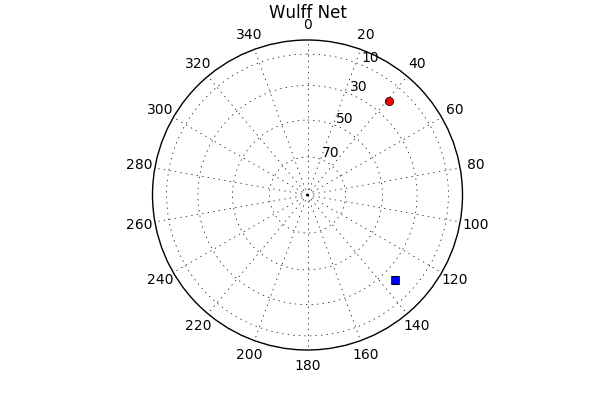

In [2]:
Image(filename='Figures/wulff.png')

Remember that both of these points are striation directions supposedly found in an ancient bedding plane.  Wouldn't it be nice to know the orientation of the plane from these two vectors? Well we can, by using the wonders of matrix math.  But first, let's review what planes are in geology and how they are described.  

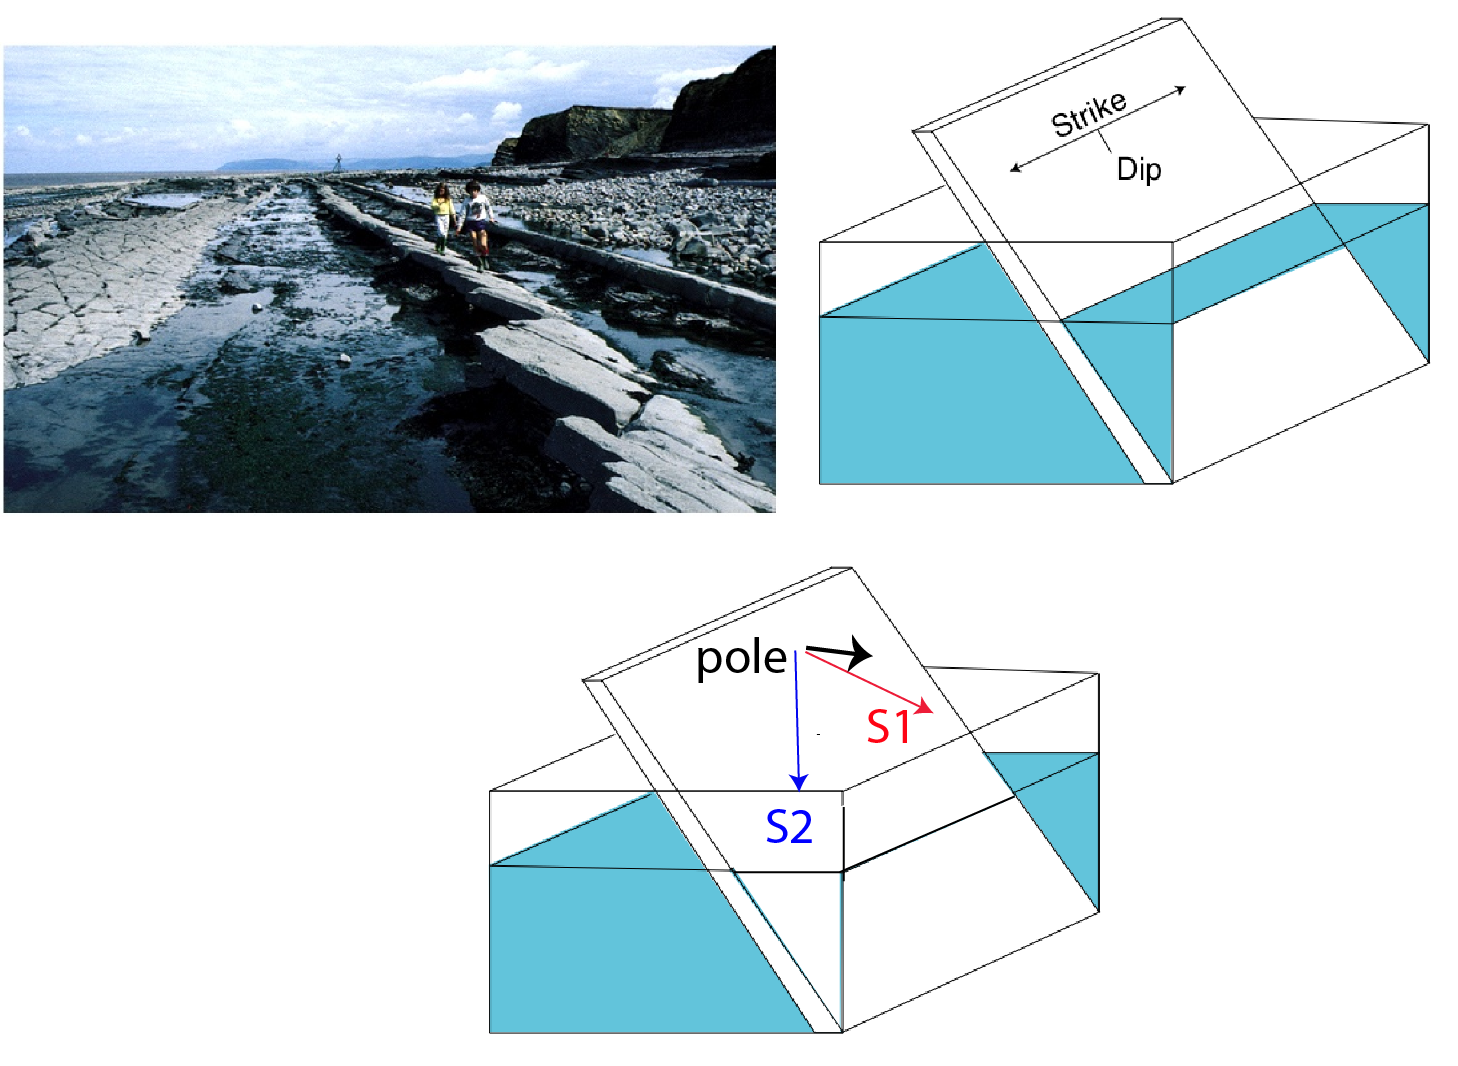

In [3]:
Image(filename='Figures/planes.png')

The top left figure is a shot of the beds exposed at ultralow tides at La Jolla Cove. Geologists describe the orientation of such beds using, for example _strike_ and _dip_ (upper right picture).  The strike is the direction of a horizontal line in the plane and the dip is the maximum angle with respect to the horizontal. By convention, dip is to the "right" of strike. 

There are   other ways to uniquely specify a plane, for example the direction of dip and the dip.  And, there is a line which is perpendicular to the plane, called the _pole_ to the plane (red arrow in the lower figure). This line is perpendicular to all lines in the plane (e.g., S1 and S2 in the figure above), not just the strike and dip lines. So, if you could measure two directions within the plane and find a line orthogonal to them, that would give you the pole.  From the pole  you could calculate the strike and dip or dip direction and dip or whatever you want!  

To get a direction that is orthogonal to two other directions (say the pole with respect to the two striation directions), we can use the wonders of matrix math, the subject of this lecture.  

First we will start with a review of vectors.  You probably know that vectors have both direction and length.  In this lecture we will not worry about the length and just focus on _unit vectors_ which have a length of one.  

### Vector addition




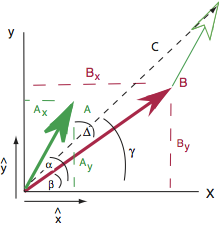

In [4]:
Image(filename='Figures/vectors.png',width=300)

_Vectors $\vec A$ and $\vec B$, their components $A_x, A_y, B_x, B_y$  and the angles between them and the $X$ axis, $\alpha$ and $\beta$.  The angle between the two vectors is $\alpha$-$\beta$ = $\Delta$.   Unit vectors in the directions of the axes are $\hat x$ and $\hat y$ respectively._ [Figure from Essentials of Paleomagnetism by Tauxe et al. (2010)](https://earthref.org/MagIC/books/Tauxe/Essentials/)



To add the two vectors  $\vec A$ and $\vec B$,  we break each
vector into components $A_{x,y}$ and $B_{x,y}$.  From trigonometry we know that $A_x=|A|\cos{\alpha},
A_y=|A|\sin{\alpha}$ where $|A|$ is the length of the vector $\vec A$.  The components of the resultant vector $\vec C$ are: $C_x = A_x +B_x$ and $C_y=A_y+B_y$.   These
can be converted back to polar coordinates of magnitude and angles if desired:

$|C| = \sqrt {C_x^2+C_y^2} \hbox{ and } \gamma= \cos^{-1} { {C_x}\over{ {|C|}}}.$ 

To do this in Python, we first have to convert the direction (given to us in the polar coordinates azimuth and plunge) to its cartesian coordinates, $V_N,V_E,V_V$ or $X,Y,Z$ or even better $X_1,X_2,X_3$ or even better still $X_i$. (Notice we are now in 3D instead of just 2D).  

And when we are through, we can convert cartesian coordinates $X_i$ data back to their 'polar' equivalents, azimuth and plunge.

Here is the figure from the last lecture:

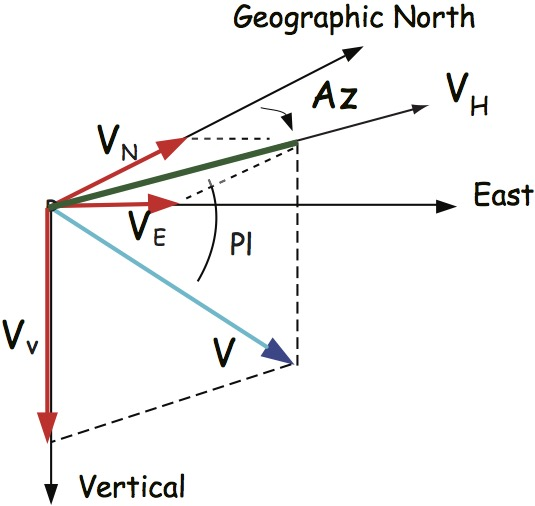

In [5]:
Image(filename='Figures/coordinates.jpg',width=300)

_Figure modified from_ [Essentials of Paleomagnetism by Tauxe et al.,(2010):](https://earthref.org/MagIC/books/Tauxe/Essentials/)
 
And here are two little functions that do the transformations for us:

In [6]:
def dir2cart(Dir):
    """
    converts polar directions to cartesian coordinates
    Parameters: 
        Dir[Azimuth,Plunge]:  directions in degreess
    Returns:
        [X,Y,Z]: cartesian coordinates
    """
    Az,Pl=np.radians(Dir[0]),np.radians(Dir[1])
    return [np.cos(Az)*np.cos(Pl),np.sin(Az)*np.cos(Pl),np.sin(Pl)]
 
def cart2dir(X):
    """
    converts cartesian coordinates to polar azimuth and plunge
    Parameters:
        X: list of X,Y,Z coordinates
    Returns: 
        [Az,Pl]: list of polar coordinates in degrees
    """
    R=np.sqrt(X[0]**2+X[1]**2+X[2]**2) # calculate resultant vector length
    Az=np.degrees(np.arctan2(X[1],X[0]))%360. # calculate declination taking care of correct quadrants (arctan2) and making modulo 360.
    Pl=np.degrees(np.arcsin(X[2]/R)) # calculate inclination (converting to degrees) #
    return [Az,Pl]



We used **cart2dir** before (in **mkigrf**), but now you can see how it is done.  

Try them out to see if they work!

In [7]:
Az,Pl=41,21   # one of our striation directions from the last lecture
X=dir2cart([Az,Pl])
print ('cartesian coordinates of X: ',X)
newAz,newPl=cart2dir(X)
print ('polar coordinates of X: ',newAz,newPl)

cartesian coordinates of X:  [0.7045820917858996, 0.6124838680922978, 0.35836794954530027]
polar coordinates of X:  41.0 21.0


Good, so that worked!  Now we can do the vector addition of two vectors by doing the sum of the cartesian coordinates and then converting back to directions.  

In [8]:
A,B=[40.9,20.7],[134.1,22.5] # striation directions from Lecture 20
X1=np.array(dir2cart(A)) # cartesian coordinates of A as a Numpy array
X2=np.array(dir2cart(B)) # cartesian coordinates of B as a Numpy array
C=X1+X2 # cartesian coordinates of vector sum using array addition
print ('Vector sum of A+B =\n',cart2dir(C)) # \n is a newline

Vector sum of A+B =
 [87.12316052185763, 29.95177458164654]


### Vector subtraction

To subtract two vectors, compute the components as in addition, but the components of the
vector difference
$\vec C$ are:  $C_x = A_x -B_x, C_y=A_y-B_y$.  

And with Numpy this is easy peasy:









In [9]:
C=X1-X2 # cartesian coordinates of vector difference
print ('Vector difference of A-B =\n',cart2dir(C)) # \n is a newline

Vector difference of A-B =
 [357.83699328653245, -1.2385764215791604]


### Vector multiplication

There are two ways to multiply vectors, the _dot product_ and the _cross product_. 

#### Dot Product
The dot product is given by $\vec A \cdot \vec B= A_xB_x + A_yB_y$.  The result is a scalar and equivalent to the cosine of the angle between the two vectors if the $\vec A$ and $\vec B$ are taken as unit vectors. 

 **NumPy** has a function **np.dot( )** which does this for us (only we have to remember about the radians and degrees thing.)  

In [10]:
delta=np.dot(X1,X2) # cartesian coordinates of dot product
print ('Angle between A,B =\n',np.degrees(np.arccos(delta))) # \n is a newline

Angle between A,B =
 85.00746647572834


### Cross Product 
 
 The other way to perform vector multiplication is the cross
product,  which  produces a vector orthogonal to both $\vec A$ and $\vec B$.  Which, by the way, is exactly what we wanted for our striations_in_the_bed problem.  

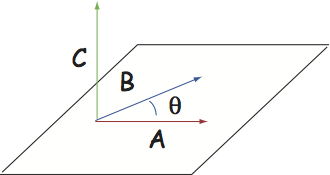

In [11]:
Image(filename='Figures/cross.png')

_Illustration of cross product of vectors $\vec A$ and $\vec B$ separated by angle $\theta$ to get the orthogonal vector $\vec C$._ [Figure modified from Essentials of Paleomagnetism by Tauxe et al.,(2010):](https://earthref.org/MagIC/books/Tauxe/Essentials/)

The  components of $\vec C$ are given by:

$
C = \det \left|\, \matrix{
\hat x & \hat y &\hat z \cr
A_x & A_y & A_z\cr
B_x & B_y & B_z\cr}\right|.
$

To calculate the determinant, we follow these rules:

$C_x=A_yB_z - A_zB_y,$

$C_y=A_zB_x - A_xB_z,$

$C_z=A_xB_y - A_yB_x.$

or

$C_i = A_jB_k-A_kB_j \hskip .25in i\neq j \neq k.
$

Once again NumPy makes this pretty easy: 



In [12]:
C=np.cross(X1,X2) # cartesian coordinates of dot product
pole=cart2dir(C)
print ('Vector orthogonal to A,B =\n',pole)

Vector orthogonal to A,B =
 [269.984603993202, 60.017293145906756]


From this you can work out the strike (must be 90 degrees away from the pole azimuth and the dip (90 degrees from the pole plunge)

In [13]:
print ('strike= ','%7.1f'%((pole[0]+90.)%360)) # %360 makes sure answer is between 0, 360
print ('dip= ','%7.1f'%(90-pole[1]))

strike=    360.0
dip=     30.0
